# Support Vector Regression (SVR): Linear Data with Sklearn

This example uses the Boston Housing Price dataset. What if we are only concerned about reducing errors of our prediction to a certain degree? What if we don’t care how large our errors are, as long as they fall within an acceptable range? What if we are okay with the prediction being within a certain dollar amount — say $5,000? We can then give our model some flexibility in finding the predicted values, as long as the error is within that range. (Note: regular linear regression tries to minimize the sum of squared errors)

In contrast to OLS, the objective function of SVR is to minimize the coefficients — more specifically, the l2-norm of the coefficient vector — not the squared error. The error term is instead handled in the constraints, where we set the absolute error less than or equal to a specified margin, called the maximum error, ϵ (epsilon). We can tune epsilon to gain the desired accuracy of our model. Our new objective function and constraints are as follows:

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error 
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

## Load data

In [2]:
# get housing price data
url = "https://raw.githubusercontent.com/tomsharp/SVR/master/data/Boston%20Housing%20Prices.csv"
df = pd.read_csv(url)
df.head()

,town,tract,longitude,latitude,crime,residential,industrial,river,nox,rooms,older,distance,highway,tax,ptratio,lstat,cmedv
0,Nahant,2011,-70.955002,42.255001,0.00632,18.0,2.31,no,0.538,6.575,65.199997,4.0900,1,296,15.300000,4.98,24.000000
1,Swampscott,2021,-70.949997,42.287498,0.02731,0.0,7.07,no,0.469,6.421,78.900002,4.9671,2,242,17.799999,9.14,21.600000
2,Swampscott,2022,-70.935997,42.283001,0.02729,0.0,7.07,no,0.469,7.185,61.099998,4.9671,2,242,17.799999,4.03,34.700001
3,Marblehead,2031,-70.928001,42.292999,0.03237,0.0,2.18,no,0.458,6.998,45.799999,6.0622,3,222,18.700001,2.94,33.400002
4,Marblehead,2032,-70.921997,42.298000,0.06905,0.0,2.18,no,0.458,7.147,54.200001,6.0622,3,222,18.700001,5.33,36.200001


## Explore data

In [3]:
# show summary statistics
df.describe(include="all")

,town,tract,longitude,latitude,crime,residential,industrial,river,nox,rooms,older,distance,highway,tax,ptratio,lstat,cmedv
count,506,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
unique,92,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Cambridge,NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,30,NaN,NaN,NaN,NaN,NaN,NaN,471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2700.355731,-71.056389,42.216440,3.613524,11.363636,11.136779,NaN,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.528854
std,NaN,1380.036830,0.075405,0.061777,8.601545,23.322453,6.860353,NaN,0.115878,0.702617,28.148862,2.105710,8.707259,168.537116,2.164946,7.141062,9.182176
min,NaN,1.000000,-71.289497,42.029999,0.006320,0.000000,0.460000,NaN,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,NaN,1303.250000,-71.093226,42.180774,0.082045,0.000000,5.190000,NaN,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,NaN,3393.500000,-71.052902,42.218100,0.256510,0.000000,9.690000,NaN,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200001
75%,NaN,3739.750000,-71.019625,42.252249,3.677083,12.500000,18.100000,NaN,0.624000,6.623500,94.074999,5.188425,24.000000,666.000000,20.200001,16.954999,25.000000


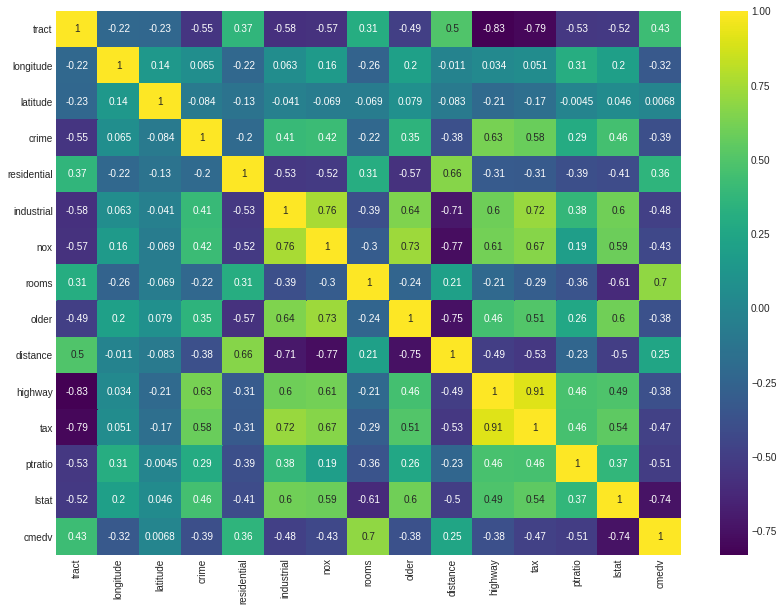

In [4]:
# plot correlation heatmap of data columns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,10))
sns.heatmap(df.corr(), annot=True, cmap="viridis", ax=ax)
plt.show()

In [5]:
# show correlations with price (cmedv) in descending order
abs(df.corr())['cmedv'].sort_values(ascending=False)

cmedv          1.000000
lstat          0.740836
rooms          0.696304
ptratio        0.505655
industrial     0.484754
tax            0.471979
nox            0.429300
tract          0.428252
crime          0.389582
highway        0.384766
older          0.377999
residential    0.360386
longitude      0.322947
distance       0.249315
latitude       0.006825
Name: cmedv, dtype: float64

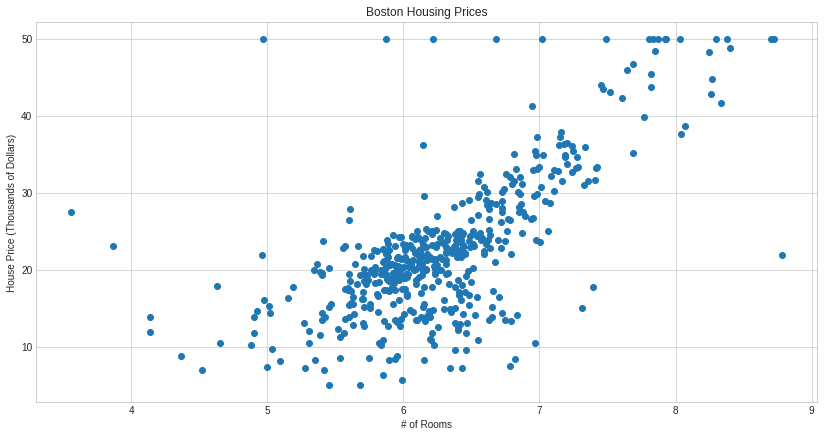

In [6]:
# plot house price against number of rooms
plt.figure(figsize=(14,7))
plt.scatter(x=df['rooms'], y=df['cmedv'])
plt.xlabel('# of Rooms')
plt.ylabel('House Price (Thousands of Dollars)')
plt.title('Boston Housing Prices')
plt.show()

## Declare targets and features

In [7]:
# create feature (X) and target (y) variables
X = np.array(df['rooms']).reshape(-1,1)
y = np.array(df['cmedv']).reshape(-1,1)

## Train-Test Split

In [8]:
# 80:20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape[0])
print(X_test.shape[0])
print(X_train.shape[0] / X.shape[0])

404
102
0.7984189723320159


## Linear Regression (to compare to linear SVR)

In [9]:
# build and train linear model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
# get parameters of linear regression
print("Intercept: {:.3f}".format(regressor.intercept_[0]))
print("Coefficient: {:.3f}".format(regressor.coef_[0][0]))

Intercept: -36.220
Coefficient: 9.345


In [11]:
# make predictions and compute error
yhat = regressor.predict(X_test)
eval_df = pd.DataFrame({"Actuals": y_test.reshape(-1), "Predictions": yhat.reshape(-1), "%-Error": np.abs(((yhat.reshape(-1)-y_test.reshape(-1))/y_test.reshape(-1))*100)})
eval_df

,Actuals,Predictions,%-Error
0,23.600000,23.737240,0.581524
1,32.400002,26.933199,16.872848
2,13.600000,19.690894,44.785984
3,22.799999,20.457179,10.275527
4,16.100000,22.625197,40.529167
...,...,...,...
97,17.900000,7.028545,60.734387
98,9.600000,24.157762,151.643341
99,17.200001,25.989364,51.100949
100,22.500000,19.989932,11.155858


In [12]:
# compute mean percentage error
eval_df.loc[:, "%-Error"].mean()

25.558546038666947

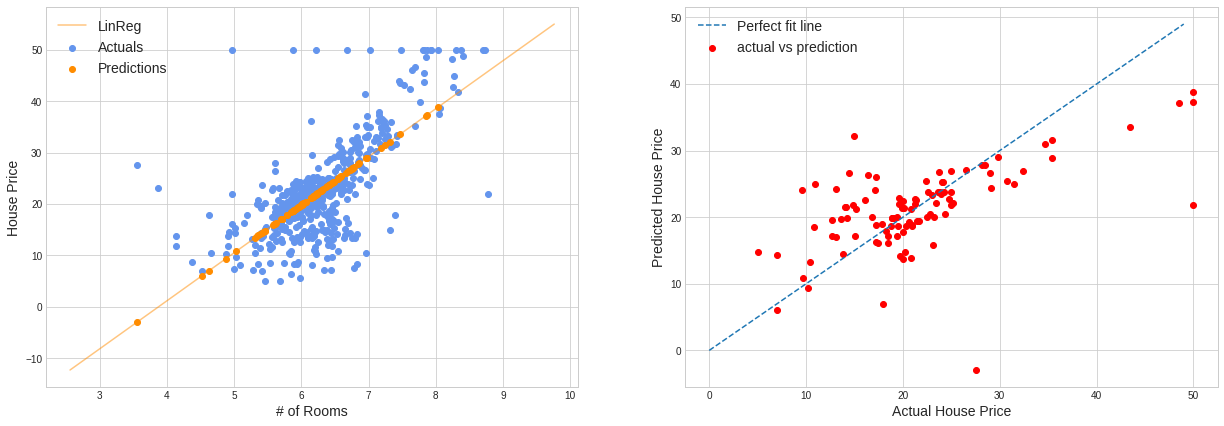

In [13]:
# plot predictions against actuals
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21,7))

axes[0].scatter(X, y, color="cornflowerblue", label="Actuals")
axes[0].scatter(X_test, yhat, color="darkorange", label="Predictions")
X_grid = np.arange(min(X)-1, max(X)+1, 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
axes[0].plot(X_grid, regressor.predict(X_grid), color = 'darkorange', alpha=0.5, label="LinReg")
axes[0].set_xlabel("# of Rooms", fontsize=14)
axes[0].set_ylabel("House Price", fontsize=14)
axes[0].legend(fontsize=14)

axes[1].scatter(y_test, yhat, color="red", label="actual vs prediction")
axes[1].plot(np.arange(0, max(y)), np.arange(0, max(y)), linestyle="dashed", label="Perfect fit line")
axes[1].set_xlabel("Actual House Price", fontsize=14)
axes[1].set_ylabel("Predicted House Price", fontsize=14)
axes[1].legend(fontsize=14)

plt.show()

## Support Vector Regression Model

In [14]:
# define function to compute regression parameters, errors, and plot regression line
def svr_results(y_test, X_test, fitted_svr_model):
    
    print("C: {}".format(fitted_svr_model.C))
    print("Epsilon: {}".format(fitted_svr_model.epsilon))
    
    print("Intercept: {:,.3f}".format(fitted_svr_model.intercept_[0]))
    print("Coefficient: {:,.3f}".format(fitted_svr_model.coef_[0]))
    
    mae = mean_absolute_error(y_test, fitted_svr_model.predict(X_test))
    print("MAE = ${:,.2f}".format(1000*mae))
    
    perc_within_eps = 100*np.sum(y_test - fitted_svr_model.predict(X_test) < eps) / len(y_test)
    print("Percentage within Epsilon = {:,.2f}%".format(perc_within_eps))
    
    # Plot outputs
    plt.figure(figsize=(14,7))
    plt.scatter(x=df['rooms'], y=df['cmedv'])
    plt.plot(X_test, fitted_svr_model.predict(X_test), color='red')
    plt.plot(X_test, fitted_svr_model.predict(X_test)+eps, color='black')
    plt.plot(X_test, fitted_svr_model.predict(X_test)-eps, color='black')
    plt.xlabel('# of Rooms')
    plt.ylabel('House Price (Thousands of Dollars)')
    plt.title('SVR Prediction')
    plt.show()

### Initial SVR Model

In [15]:
# build and train model
eps = 5
svr = LinearSVR(epsilon=eps, C=0.01, fit_intercept=True)
svr.fit(X_train, y_train.ravel())

LinearSVR(C=0.01, dual=True, epsilon=5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

C: 0.01
Epsilon: 5
Intercept: 0.376
Coefficient: 3.216
MAE = $5,209.97
Percentage within Epsilon = 7,899.02%


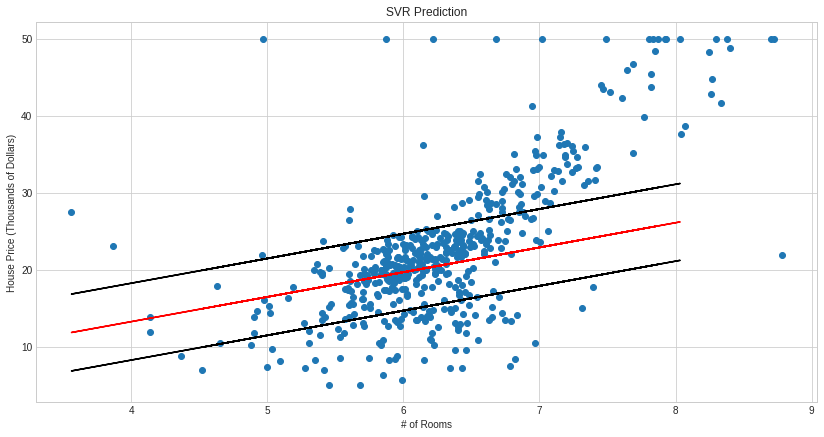

In [16]:
# show coefficients, errors, plots etc.
svr_results(y_test, X_test, svr)

You may quickly realize that this algorithm doesn’t work for all data points. The algorithm solved the objective function as best as possible but some of the points still fall outside the margins. As such, we need to account for the possibility of errors that are larger than ϵ. We can do this with slack variables.

### SVR model with larger penalty (regularization parameter C)

In [17]:
# build and train model
eps = 5
svr_high_C = LinearSVR(epsilon=eps, C=1.0, fit_intercept=True)
svr_high_C.fit(X_train, y_train.ravel())

LinearSVR(C=1.0, dual=True, epsilon=5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

C: 1.0
Epsilon: 5
Intercept: -10.164
Coefficient: 5.240
MAE = $4,895.51
Percentage within Epsilon = 8,274.51%


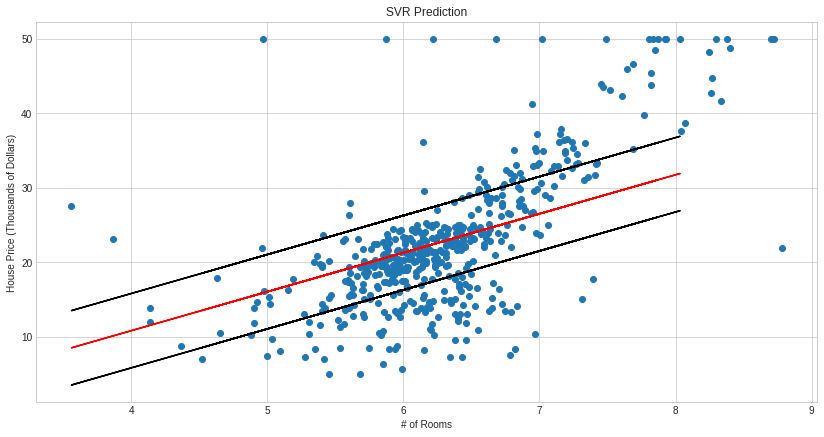

In [18]:
# show coefficients, errors, plots etc.
svr_results(y_test, X_test, svr_high_C)

We now have an additional hyperparameter, C, that we can tune. As C increases, our tolerance for points outside of ϵ also increases. As C approaches 0, the tolerance approaches 0 and the equation collapses into the simplified (although sometimes infeasible) one. More points are within our margin (epsilon), since we increased C to 1.0.

### Vary C via grid search for best value

In [19]:
# run loop over diff values of C and record MAE's and percentage of test targets within epsilon interval
test_mae_list = []
perc_within_eps_list = []

eps = 5
c_space = np.linspace(0.01, 10)

for c in c_space:
    varied_svr = LinearSVR(epsilon=eps, C=c, fit_intercept=True, max_iter=10000)
    varied_svr.fit(X_train, y_train.ravel())

    varied_yhat = varied_svr.predict(X_test)
    
    test_mae = mean_absolute_error(y_test, varied_yhat)
    test_mae_list.append(test_mae)
    
    perc_within_eps = 100*(np.sum(abs(y_test.reshape(-1)-varied_yhat) <= eps) / len(y_test))
    perc_within_eps_list.append(perc_within_eps)

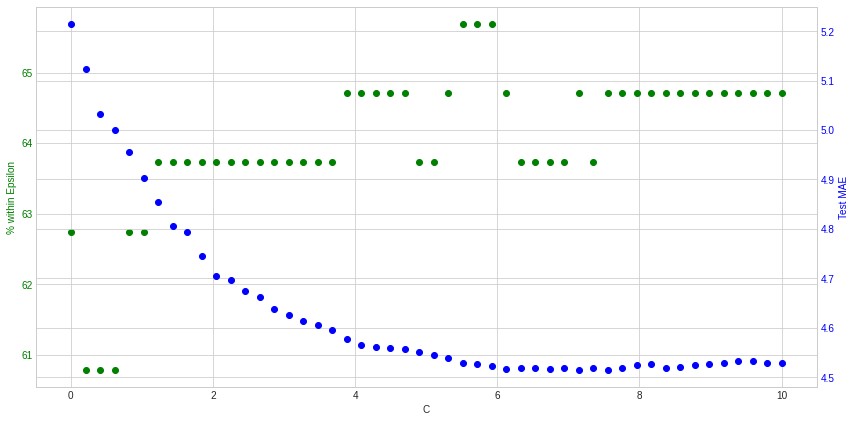

In [20]:
# plot results of loop 
fig, ax1 = plt.subplots(figsize=(14,7))

color='green'
ax1.set_xlabel('C')
ax1.set_ylabel('% within Epsilon', color=color)
ax1.scatter(c_space, perc_within_eps_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color='blue'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Test MAE', color=color)  # we already handled the x-label with ax1
ax2.scatter(c_space, test_mae_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

In [21]:
# find best regularization parameter C via maximum epsilon interval percentage
m = max(perc_within_eps_list)
inds = [i for i, j in enumerate(perc_within_eps_list) if j == m]
C = c_space[inds[0]]

print("best C =", C)

best C = 5.514693877551021


C: 5.514693877551021
Epsilon: 5
Intercept: -29.294
Coefficient: 8.234
MAE = $4,532.34
Percentage within Epsilon = 7,795.10%


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


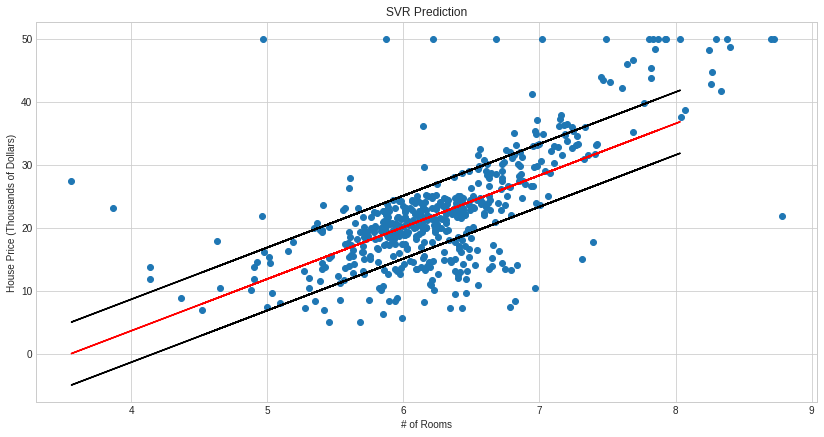

In [22]:
# build and train model with this best C
eps = 5
svr_best_C = LinearSVR(epsilon=eps, C=C, fit_intercept=True)
svr_best_C.fit(X_train, y_train.ravel())
svr_results(y_test, X_test, svr_best_C)

The plot above shows that this model has again improved upon previous ones, as expected.

## Grid search over C and Epsilon

In [23]:
# define value space for which C and epsilon should be tested
grid = {
    'C': np.linspace(0.01, 10),
    'epsilon': np.linspace(0.01, 10)
}
    
svr_gridsearch =  LinearSVR(fit_intercept=True, max_iter=1000)

### Scoring criteria: MAE

In [ ]:
# run grid search with MAE as scoring criteria
grid_svr = GridSearchCV(svr_gridsearch, grid, scoring='neg_mean_absolute_error', cv=5)
grid_svr.fit(X_train, y_train.ravel())

In [25]:
# get MAE and train model 
best_grid_svr_mae = grid_svr.best_estimator_
best_grid_svr_mae.fit(X_train, y_train.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=9.796122448979592, dual=True, epsilon=1.233265306122449,
          fit_intercept=True, intercept_scaling=1.0, loss='epsilon_insensitive',
          max_iter=1000, random_state=None, tol=0.0001, verbose=0)

C: 9.796122448979592
Epsilon: 1.233265306122449
Intercept: -34.406
Coefficient: 9.159
MAE = $4,544.56
Percentage within Epsilon = 7,884.31%


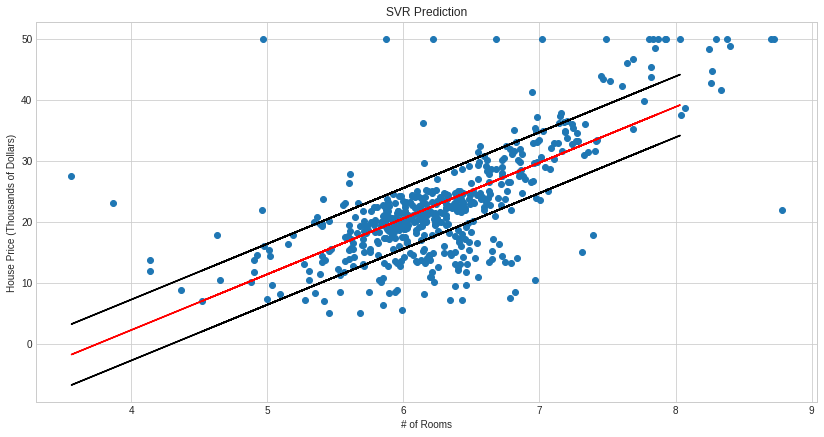

In [26]:
# show and plot results
svr_results(y_test, X_test, best_grid_svr_mae)

### Scoring criteria: % within Epsilon

In [27]:
# define function to capture % within epsilon and create scorer
def frac_within_eps(y_true, y_pred):
    return np.sum(abs(y_true-y_pred) <= eps) / len(y_true)

my_scorer = make_scorer(frac_within_eps, greater_is_better=True)

In [ ]:
# run grid search with % within epsilon as scoring criteria
grid_svr_eps = GridSearchCV(svr_gridsearch, grid, scoring=my_scorer, cv=5)
grid_svr_eps.fit(X_train, y_train.ravel())

In [29]:
# build and train model
best_grid_svr_eps = grid_svr_eps.best_estimator_
best_grid_svr_eps.fit(X_train, y_train.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=8.368979591836734, dual=True, epsilon=1.029387755102041,
          fit_intercept=True, intercept_scaling=1.0, loss='epsilon_insensitive',
          max_iter=1000, random_state=None, tol=0.0001, verbose=0)

C: 8.368979591836734
Epsilon: 1.029387755102041
Intercept: -33.776
Coefficient: 9.055
MAE = $4,545.08
Percentage within Epsilon = 7,893.14%


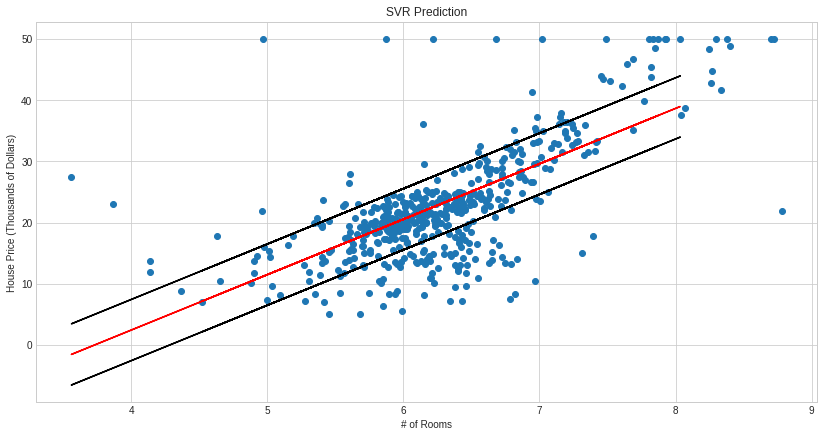

In [30]:
# show and plot results
svr_results(y_test, X_test, best_grid_svr_eps)